<a href="https://colab.research.google.com/github/hypro2/LLM-Multimodal-Colab/blob/main/resnet_GPT2_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image

from transformers import GPT2Tokenizer, GPT2Model # 텍스트

from tqdm.auto import tqdm

In [51]:
class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=8,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=8,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

In [52]:
class VQAModel(nn.Module):
    def __init__(self, vocab_size):
        super(VQAModel, self).__init__()
        self.vocab_size = vocab_size

        self.resnet = models.resnet50(pretrained=True)
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(vocab_size) # 추가한 [PAD] 토큰 반영

        combined_features_size = 1000 + self.gpt2.config.hidden_size # resnet 출력 차원 + gpt2 출력 차원
        self.classifier = nn.Linear(combined_features_size, vocab_size)

    def forward(self, images, question):
        image_features = self.resnet(images)
        image_features = image_features.view(image_features.size(0),-1)

        outputs = self.gpt2(question)
        output_features = outputs.last_hidden_state # [batch, sequence, hidden]

        image_features = image_features.unsqueeze(1).expand(-1, output_features.size(1),-1) # [batch, sequence, 1000]

        combined = torch.cat([image_features, output_features], dim=-1) # [batch, sequence, 1000+hidden]
        output = self.classifier(combined) # [batch, vocab_size]
        return output

In [69]:
train_df ={"image_id":["download"],"question":["A giraffe I drew"],"answer":["A giraffe you drew"]}
train_df = pd.DataFrame(train_df)
train_df

,image_id,question,answer
0,download,A giraffe I drew,A giraffe you drew


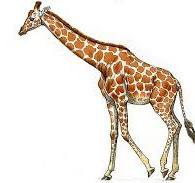

In [80]:
from PIL import Image

image = Image.open("/content/download.jpg")
image

In [70]:
# dataset & dataloader
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_df, tokenizer, transform, "/content", is_test=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [71]:
train_dataset[0]

{'image': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.64

In [72]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in tqdm(loader, total=len(loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        answer = data['answer'].to(device)

        optimizer.zero_grad()

        outputs = model(images, question)

        # output: [batch, sequence, vocab], answer : [batch, sequence]
        loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(loader)
    return avg_loss

In [73]:
def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)

            outputs = model(images, question) # [batch, sequence, vocab]

            _, pred = torch.max(outputs, dim=2) # values, indices = _, pred
            preds.extend(pred.cpu().numpy())

    return preds

In [77]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

# Model
model = VQAModel(vocab_size).to(device)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
for epoch in range(30):
    avg_loss = train(model, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

current device is cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Loss: 17.4062


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Loss: 14.5296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Loss: 16.2418


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Loss: 15.2363


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Loss: 13.7738


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Loss: 10.6583


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Loss: 10.9521


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Loss: 9.5828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Loss: 8.5966


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Loss: 8.7678


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Loss: 7.0897


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Loss: 5.5410


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Loss: 4.9466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Loss: 5.0623


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Loss: 5.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Loss: 4.5660


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Loss: 3.9349


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Loss: 4.0020


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Loss: 3.1936


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20, Loss: 3.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21, Loss: 2.9558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22, Loss: 2.4039


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23, Loss: 2.0255


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24, Loss: 1.7760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25, Loss: 1.6154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26, Loss: 1.4387


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27, Loss: 1.2722


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28, Loss: 1.2315


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.8688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.7072


In [78]:
# Dataset & DataLoader
test_dataset = VQADataset(train_df, tokenizer, transform,  "/content", is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# inference
preds = inference(model, test_loader)

no_pad_output = []
for pred in preds:
    output = pred[pred != 50257] # [PAD] token 제외
    no_pad_output.append(tokenizer.decode(output).strip()) # 토큰 id -> 토큰

  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
no_pad_output

['A giraffe youaffe']